In [8]:
import numpy as np
import pandas as pd
from easypreprocessing import EasyPreProcessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D

In [2]:
prep = EasyPreProcessing('data.csv')


**Initialization Parameters**

1.  output            - Set output variable/dependent variable
2.  dates.features    - Set datetime field names (optional)

For example:
1.  output = 'column_name'
2.  dates.features = ['date_field_1','date_field_2']
        

In [3]:
prep.df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


In [4]:
prep.dataset['key'] = prep.df['week'].astype(str) + '_' + prep.df['store_id'].astype(str) 

In [5]:
prep.dataset = prep.df.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)

In [6]:
prep.dataset = prep.df.groupby('key').sum()

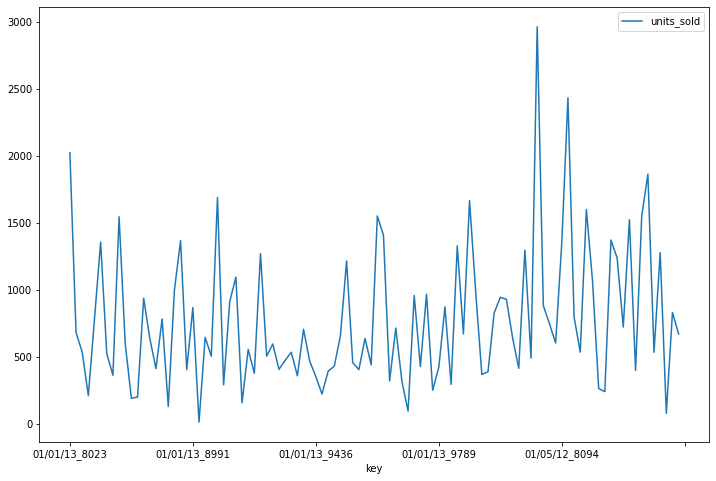

In [7]:
prep.df[:100].plot(figsize=(12,8))
dataset = prep

In [9]:
dataset = dataset.df
seq_size = 10 
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size

dataset = dataset.values
dataset = dataset.astype('float32') 

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [10]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (6509, 10)
Shape of test set: (3349, 10)


In [11]:
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


Epoch 1/100
204/204 - 2s - loss: 0.0105 - val_loss: 0.0089 - 2s/epoch - 12ms/step
Epoch 2/100
204/204 - 0s - loss: 0.0082 - val_loss: 0.0064 - 417ms/epoch - 2ms/step
Epoch 3/100
204/204 - 0s - loss: 0.0064 - val_loss: 0.0055 - 476ms/epoch - 2ms/step
Epoch 4/100
204/204 - 0s - loss: 0.0056 - val_loss: 0.0046 - 423ms/epoch - 2ms/step
Epoch 5/100
204/204 - 1s - loss: 0.0049 - val_loss: 0.0037 - 537ms/epoch - 3ms/step
Epoch 6/100
204/204 - 0s - loss: 0.0044 - val_loss: 0.0035 - 427ms/epoch - 2ms/step
Epoch 7/100
204/204 - 0s - loss: 0.0040 - val_loss: 0.0030 - 418ms/epoch - 2ms/step
Epoch 8/100
204/204 - 0s - loss: 0.0036 - val_loss: 0.0029 - 461ms/epoch - 2ms/step
Epoch 9/100
204/204 - 0s - loss: 0.0034 - val_loss: 0.0027 - 423ms/epoch - 2ms/step
Epoch 10/100
204/204 - 0s - loss: 0.0033 - val_loss: 0.0024 - 426ms/epoch - 2ms/step
Epoch 11/100
204/204 - 0s - loss: 0.0030 - val_loss: 0.0023 - 418ms/epoch - 2ms/step
Epoch 12/100
204/204 - 0s - loss: 0.0028 - val_loss: 0.0030 - 467ms/epoch - 

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

Train Score: 190.20 RMSE
Test Score: 195.67 RMSE


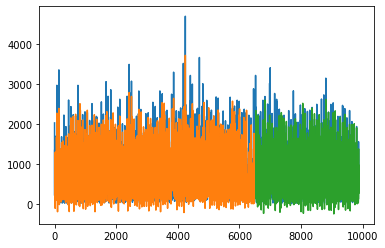

In [15]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()